In [ ]:
#PROBLEM 1: STUDY RESPONSE TO AN EVENT

In [ ]:
#PART A: SUPERBOWL LI EVENT
#Tweets are stored in the database Test.sqlite in Tweets table while Locations collected are stored in the Locations table.
#The tweets and locations can be directly loaded from these tables.

In [ ]:
#Installing the necessary pakcages
install.packages("twitteR")
install.packages("RCurl")
install.packages("RJSONIO")
install.packages("stringr")
install.packages("ggmap")

In [2]:
#Loading the libraries
library("twitteR")
library("RCurl")
library("RJSONIO")
library("stringr")

Loading required package: bitops


In [3]:
#Setting up Twitter Connection
api_key <- "ivfmBNNLieQKlo03pkByNVMYu"
api_secret <- "AWWos01ur84W8izPM904X0llxNBlEk9rnboStzcYXM1ZECOgxD"
token <- "773354810095628294-I1BOeC1mmki1WUTazJosYVLVV9g07Uv"
token_secret <- "j4ZtTVWt9EC34jx2JGX7ewcHUeIbyrDdiXgsNZPv0ziKv"
setup_twitter_oauth(api_key, api_secret, token, token_secret)

[1] "Using direct authentication"


In [51]:
#Searching for tweets
tweets <- searchTwitter("#Superbowl LI", n=500)
tweets.df <- twListToDF(tweets)

In [1]:
#Packages for SQL DB Connection 
#Referred from https://www.r-bloggers.com/r-and-sqlite-part-1/
install.packages("sqldf")
install.packages("XLConnect")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘XLConnectJars’, ‘rJava’

Warning message in install.packages("XLConnect"):
“installation of package ‘rJava’ had non-zero exit status”Warning message in install.packages("XLConnect"):
“installation of package ‘XLConnectJars’ had non-zero exit status”Warning message in install.packages("XLConnect"):
“installation of package ‘XLConnect’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [4]:
#Loading the library 'sqldf'
library("sqldf")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


In [52]:
#Connecting to the database Test.sqliite and writing the tweets to Tweets table
db <- dbConnect(SQLite(), dbname="Test.sqlite")
try(
    {
     dbWriteTable(conn = db, name = "Tweets", value = tweets.df, row.names = FALSE,append=TRUE)   
    })

[1] TRUE

In [27]:
#dbListTables(db)
#dbListFields(db, "Tweets")

[1] "Tweets"

[1] "text"          "favorited"     "favoriteCount" "replyToSN"    
 [5] "created"       "truncated"     "replyToSID"    "id"           
 [9] "replyToUID"    "statusSource"  "screenName"    "retweetCount" 
[13] "isRetweet"     "retweeted"     "longitude"     "latitude"

In [53]:
#Counting the number of tweets
sqldf("SELECT COUNT(*) FROM Tweets", dbname = "Test.sqlite") 

COUNT(*)
7350


In [54]:
#Selecting unique users from the table
unique =sqldf("SELECT DISTINCT screenName FROM Tweets", dbname = "Test.sqlite")
nrow(unique)

[1] 517

In [55]:
#List of locations of the unique users
location_list = list()
n = nrow(unique)
k=1
for(i in c(1:n))
    {
    name = unique$screenName[i]
    user =getUser(name)
    loc = location(user)
    if(loc != "")
        {
        location_list[k]= loc
        k=k+1
    }
}

In [60]:
length(location_list)

[1] 369

In [61]:
#location_list[2]

[[1]]
[1] "Europe"

In [1]:
#Loading the library
library(ggmap)

Loading required package: ggplot2


In [64]:
#Obtaining the geocode for the locations.
coord = data.frame(lon = numeric(),lat = numeric())
for(i in location_list)
    {
    try({
        code <- geocode(i, output = "latlon" , source = "google")
        #print(code)
        if(is.numeric(code$lon) & is.numeric(code$lat))
            {
            coord = rbind(coord,code)
            #print(coord)
        }
    })
}

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Croatia&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Europe&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Munich,%20Germany&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Worldwide&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=entre%20tus%20piernas&sensor=false
Warning message:
“geocode failed with status ZERO_RESULTS, location = "entre tus piernas"”Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=France&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Scotland,%20United%20Kingdom&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Tremelo%20(Belgium)&sensor=false
Information from URL : http://maps.googleapis

In [115]:
nrow(coord)
#Getting unique locations
unique_coord = unique(coord)
nrow(unique_coord)

[1] 338

[1] 233

In [127]:
#geo_info = revgeocode(c(unique_coord$lon[220], unique_coord$lat[220]), output = "more")

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=30.6743643,-96.3699632&sensor=false


In [132]:
#state_info = geo_info$administrative_area_level_1
#state_info = as.character(state_info)
#class(state_info)

[1] "character"

In [79]:
#i=220
#lat = unique_coord$lat[i]
#lon = unique_coord$lon[i]
#geo_info = revgeocode(c(lon,lat),output="more")
#geo_info

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=31,-96&sensor=false


address,route,locality,administrative_area_level_2,administrative_area_level_1,country,postal_code
"Honeysuckle Rd, Normangee, TX 77871, USA",Honeysuckle Road,Normangee,Madison County,Texas,United States,77871


In [142]:
#Determining the states of the locations and filtering out locations only in the USA.

m=1
states = list()
for(i in (1:nrow(unique_coord)))
    {
        lat = unique_coord$lat[i]
        lon = unique_coord$lon[i]
        try(
            {
                geo_info = revgeocode(c(lon,lat),output="more")
                if(geo_info$country == "United States" | geo_info$country == "US")
                {
                    loc = geo_info$administrative_area_level_1
                    loc = as.character(loc)
                    states[m] = loc
                    m = m+1
            }
        })
}

#Storing the states in a dataframe
states.df <- data.frame(matrix(unlist(states), nrow=m-1, byrow=T))

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=45.1,15.2&sensor=false
Warning message in revgeocode(c(lon, lat), output = "more"):
“reverse geocode failed - bad location? location = "15.2551187"reverse geocode failed - bad location? location = "54.5259614"”Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=48.1351253,11.5819806&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=43.8169837,-79.532157&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=46.227638,2.213749&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=56.4906712,-4.2026458&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=50.9911642,4.7037297&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=15.870032,100.992541&sensor=false
Information from URL : http://ma

[[1]]
[1] "Wisconsin"

[[2]]
[1] "Illinois"

[[3]]
[1] "Illinois"

[[4]]
[1] "California"

[[5]]
[1] "Illinois"

[[6]]
[1] "Texas"

[[7]]
[1] "California"

[[8]]
[1] "New York"

[[9]]
[1] "Massachusetts"

[[10]]
[1] "Florida"

[[11]]
[1] "Nevada"

[[12]]
[1] "Missouri"

[[13]]
[1] "New York"

[[14]]
[1] "Michigan"

[[15]]
[1] "Massachusetts"

[[16]]
[1] "Florida"

[[17]]
[1] "Pennsylvania"

[[18]]
[1] "Florida"

[[19]]
[1] "Mississippi"

[[20]]
[1] "Massachusetts"

[[21]]
[1] "California"

[[22]]
[1] "California"

[[23]]
[1] "Wyoming"

[[24]]
[1] "Florida"

[[25]]
[1] "District of Columbia"

[[26]]
[1] "Virginia"

[[27]]
[1] "California"

[[28]]
[1] "Colorado"

[[29]]
[1] "Kentucky"

[[30]]
[1] "Pennsylvania"

[[31]]
[1] "New York"

[[32]]
[1] "Illinois"

[[33]]
[1] "Massachusetts"

[[34]]
[1] "Texas"

[[35]]
[1] "Pennsylvania"

[[36]]
[1] "Florida"

[[37]]
[1] "Georgia"

[[38]]
[1] "Washington"

[[39]]
[1] "California"

[[40]]
[1] "Michigan"

[[41]]
[1] "New Jersey"

[[42]]
[1] "Massa

[1] 122

In [144]:
#Renaming the first column of the data frame.
colnames(states.df) <- "States"

States
Wisconsin
Illinois
Illinois
California
Illinois
Texas
California
New York
Massachusetts
Florida


In [5]:
#Connecting to the database
db <- dbConnect(SQLite(), dbname="Test.sqlite")

In [145]:
#Writing the states data frame to  a new table called Locations.
try(
    {
     dbWriteTable(conn = db, name = "Locations", value = states.df, row.names = FALSE,append=TRUE)   
    })

[1] TRUE

In [146]:
#dbListTables(db) 

[1] "Locations" "Tweets"

In [7]:
#Grouping the states using group by
group = sqldf("SELECT STATES,COUNT(*) as Size FROM LOCATIONS GROUP BY STATES ORDER BY COUNT(*) DESC" , dbname = "Test.sqlite") 

Loading required package: tcltk


In [6]:
#Loading the required libraries for plotting
library("ggplot2")
library("ggmap")
library("maps")

In [8]:
#Plotting the USA map
#Referred from http://eriqande.github.io/rep-res-web/lectures/making-maps-with-R.html
usa <- map_data("usa")
usa_map = ggplot() + geom_polygon(data = usa, aes(x=long, y = lat, group = group), fill = NA, color = "black") + coord_fixed(1.3)
#usa_map

In [9]:
#Plotting the states according to their count
for(i in (1:nrow(group)))
    {
    state = group$States[i]
    count = group$Size[i]
    code = geocode(state)
    usa_map = usa_map + geom_point(data=code,aes(x = lon , y = lat), color = "red", size = count) 
}

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=New%20York&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Massachusetts&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Florida&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=California&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Georgia&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Illinois&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Pennsylvania&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Texas&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Connecticut&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json

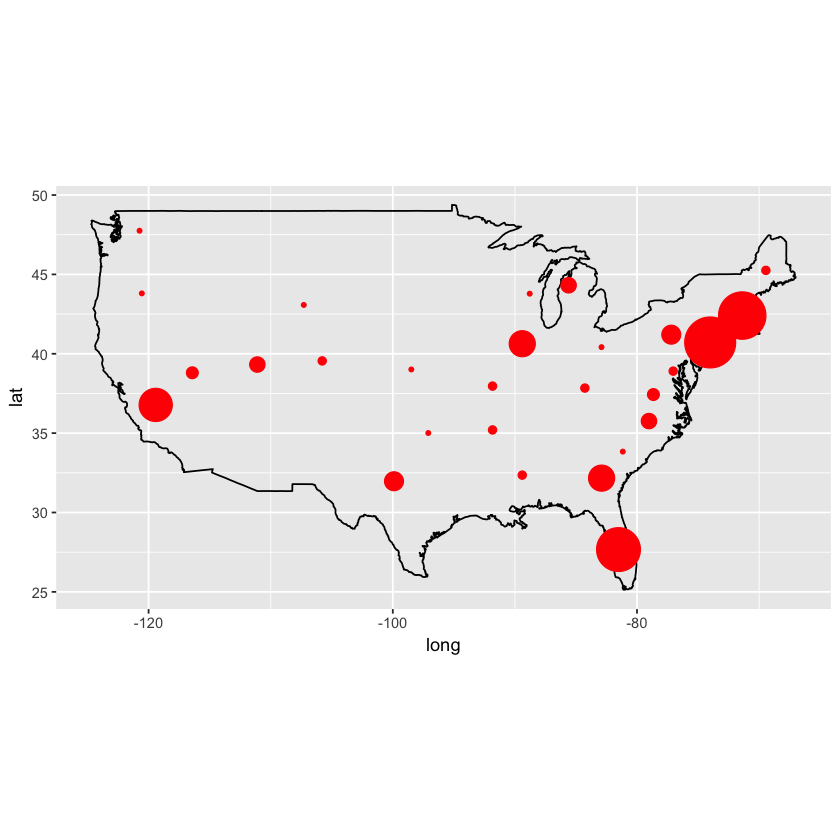

In [10]:
#OUTPUT: States with size of the blob representing the density of tweets.
usa_map

In [ ]:
#PART 2: GENERALIZING THE SOLUTION

In [36]:
#Loading the libraries
library("twitteR")
library("RCurl")
library("RJSONIO")
library("stringr")

In [37]:
#Setting up Twitter Connection
api_key <- "ivfmBNNLieQKlo03pkByNVMYu"
api_secret <- "AWWos01ur84W8izPM904X0llxNBlEk9rnboStzcYXM1ZECOgxD"
token <- "773354810095628294-I1BOeC1mmki1WUTazJosYVLVV9g07Uv"
token_secret <- "j4ZtTVWt9EC34jx2JGX7ewcHUeIbyrDdiXgsNZPv0ziKv"
setup_twitter_oauth(api_key, api_secret, token, token_secret)

[1] "Using direct authentication"


In [38]:
#INPUT THE SEARCH VARIABLE
search = "#HarryPotter"

In [39]:
#Searching for tweets
tweets_search <- searchTwitter(search, n=25)
tweets_search.df <- twListToDF(tweets_search)

In [40]:
#Loading the library 'sqldf'
library("sqldf")

In [41]:
#Connecting to the database Test.sqliite
db <- dbConnect(SQLite(), dbname="Test.sqlite")

In [42]:
#Removing # for defining the table name
value = "#"
table_name = search
#table_name
if(grepl(value,table_name))
    {
     table_name = gsub("#","", table_name)
}
#table_name

In [43]:
#Defining the table name for storing the tweets
table_name = paste(table_name,"table",sep="")
table_name

[1] "HarryPottertable"

In [44]:
try(
    {
     dbWriteTable(conn = db, name = table_name, value = tweets_search.df, row.names = FALSE,append=TRUE)   
    })

[1] TRUE

In [45]:
#Selecting unique users from the table
query = paste("SELECT DISTINCT screenName FROM",table_name)
#query
unique =sqldf(query, dbname = "Test.sqlite")
nrow(unique)

[1] 19

In [46]:
#List of locations of the unique users
location_list = list()
n = nrow(unique)
k=1
for(i in c(1:n))
    {
    name = unique$screenName[i]
    user =getUser(name)
    loc = location(user)
    if(loc != "")
        {
        location_list[k]= loc
        k=k+1
    }
}

In [47]:
length(location_list)

[1] 15

In [48]:
#Loading the library
library(ggmap)

Loading required package: ggplot2


In [49]:
#Obtaining the geocode for the locations.
coord = data.frame(lon = numeric(),lat = numeric())
for(i in location_list)
    {
    try({
        code <- geocode(i, output = "latlon" , source = "google")
        #print(code)
        if(is.numeric(code$lon) & is.numeric(code$lat))
            {
            coord = rbind(coord,code)
            #print(coord)
        }
    })
}

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Venezuela&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Utah&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Venezuela&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Tampa&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Florida,%20USA&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Usually%20In%20Manchester&sensor=false
Warning message:
“geocode failed with status ZERO_RESULTS, location = "Usually In Manchester"”Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Madrid,%20Spain&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Florida&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode

In [50]:
nrow(coord)
#Getting unique locations
unique_coord = unique(coord)
nrow(unique_coord)

[1] 14

[1] 12

In [51]:
#Determining the states of the locations and filtering out locations only in the USA.

m=1
states = list()
for(i in (1:nrow(unique_coord)))
    {
        lat = unique_coord$lat[i]
        lon = unique_coord$lon[i]
        try(
            {
                geo_info = revgeocode(c(lon,lat),output="more")
                if(geo_info$country == "United States" | geo_info$country == "US")
                {
                    loc = geo_info$administrative_area_level_1
                    loc = as.character(loc)
                    states[m] = loc
                    m = m+1
            }
        })
}

#Storing the states in a dataframe
states.df <- data.frame(matrix(unlist(states), nrow=m-1, byrow=T))

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=6.42375,-66.58973&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=39.3209801,-111.0937311&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=27.950575,-82.4571776&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=27.6648274,-81.5157535&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.4167754,-3.7037902&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=-20.2642764,-40.420365&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=-12.579738,-41.7007272&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=52.3555177,-1.1743197&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=41.87811

In [52]:
#Renaming the first column of the data frame.
colnames(states.df) <- "States"

In [53]:
#Connecting to the database
db <- dbConnect(SQLite(), dbname="Test.sqlite")

In [54]:
#Removing # for defining the table name
value = "#"
table_name = search
#table_name
if(grepl(value,table_name))
    {
     table_name = gsub("#","", table_name)
}
locations_table = paste(table_name,"Locations",sep="")

In [55]:
#Writing the states data frame to  a new table called Locations.
try(
    {
     dbWriteTable(conn = db, name = locations_table, value = states.df, row.names = FALSE,append=TRUE)   
    })

[1] TRUE

In [63]:
#Grouping the states using group by
query = paste("SELECT STATES,COUNT(*) as Size FROM",locations_table,"GROUP BY STATES ORDER BY COUNT(*) DESC")
query
group = sqldf(query , dbname = "Test.sqlite") 

[1] "SELECT STATES,COUNT(*) as Size FROM HarryPotterLocations GROUP BY STATES ORDER BY COUNT(*) DESC"

In [57]:
#Loading the required libraries for plotting
library("ggplot2")
library("ggmap")
library("maps")

In [71]:
#Plotting the USA map
#Referred from http://eriqande.github.io/rep-res-web/lectures/making-maps-with-R.html
usa <- map_data("usa")
usa_map = ggplot() + geom_polygon(data = usa, aes(x=long, y = lat, group = group), fill = NA, color = "black") + coord_fixed(1.3)
#usa_map

In [72]:
#Plotting the states according to their count
for(i in (1:nrow(group)))
    {
    state = group$States[i]
    count = group$Size[i]
    code = geocode(state)
    usa_map = usa_map + geom_point(data=code,aes(x = lon , y = lat), color = "red", size = (count*5))
}

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Florida&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=California&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Illinois&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=New%20York&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Utah&sensor=false


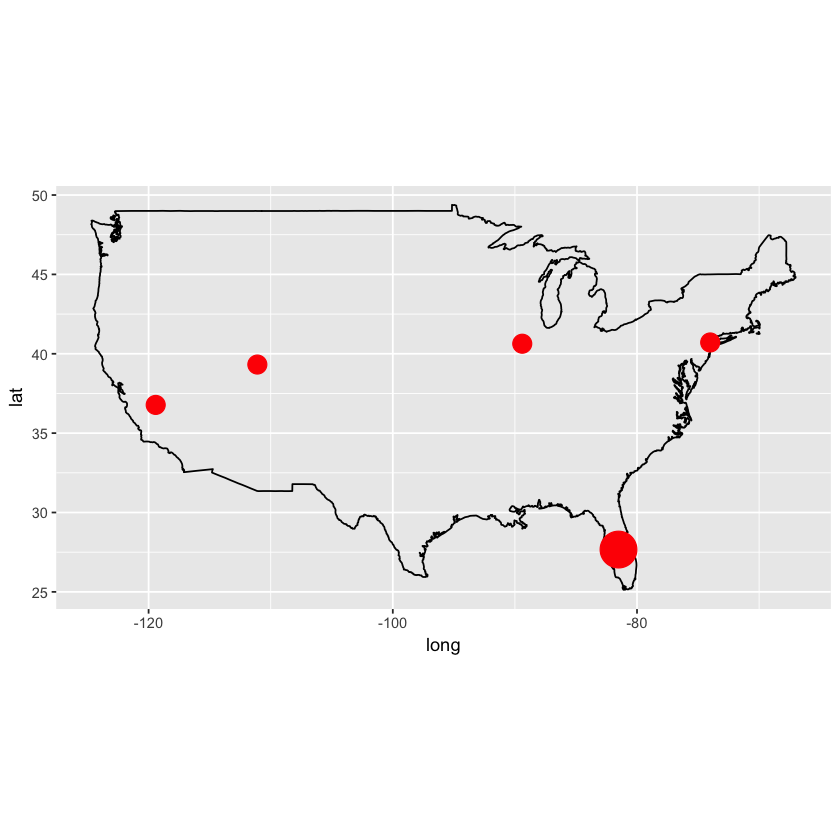

In [73]:
#OUTPUT: States with size of the blob representing the density of tweets.
usa_map